# PART III
## Kernel perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from helpers import *
from collections import Counter

np.random.seed(1234)  # give a fixed seed for reproducability
from sklearn.model_selection import train_test_split

In [2]:
#loading data
zipcombo = np.loadtxt('zipcombo.dat')
zipcombo_qater = zipcombo[:len(zipcombo)//1]
training_data = np.loadtxt('dtrain123.dat')
test_data = np.loadtxt('dtest123.dat')
x_data, y_labels = split_into_data_and_labels(zipcombo_qater)

#some training data is continuous, need to make sure everything is either -1 or 1

(257,)


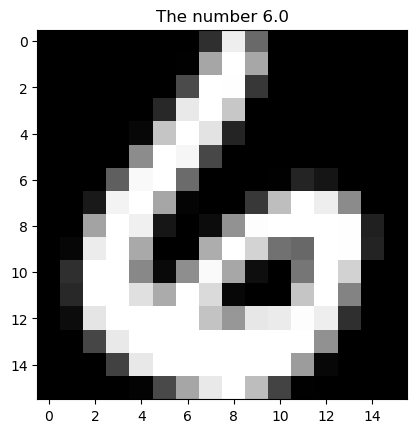

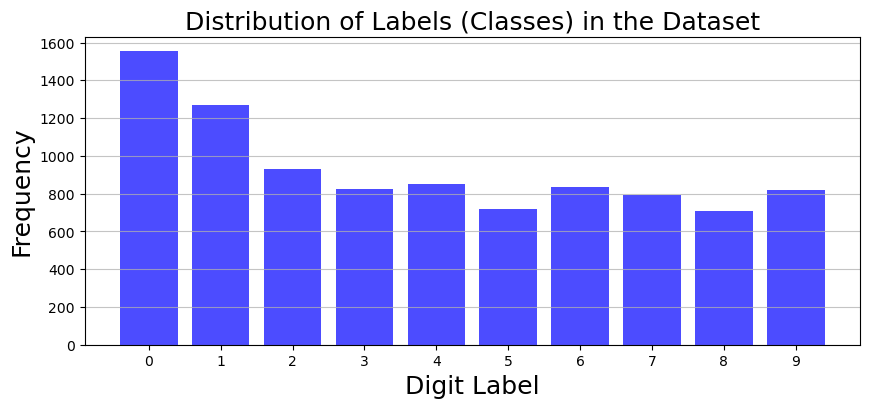

In [3]:
#plot first char
def plot_char(char):
    data = char[1:].reshape(16, 16)
    plt.imshow(data, cmap='gray')
    plt.title(f"The number {char[0]}")
    plt.show()
print(zipcombo_qater[0].shape)
    
plot_char(zipcombo_qater[0])

def plot_label_distribution(labels):
    plt.figure(figsize=(10, 4),dpi=100)
    plt.hist(labels, bins=np.arange(11) - 0.5, rwidth=0.8, color='blue', alpha=0.7)
    plt.title("Distribution of Labels (Classes) in the Dataset",fontsize=18)
    plt.xlabel("Digit Label",fontsize=18)
    plt.ylabel("Frequency",fontsize=18)
    plt.xticks(range(10))
    plt.grid(axis='y', alpha=0.75)
    plt.show()
    plt.savefig('label_distribution.png')
    
plot_label_distribution(y_labels)

In [4]:
##helper functions(can be extracted into a separate class later)

#polynomial kernel

def polynomial_kernel(p, q, d):
    return (1 + (p@q.T)) ** d

def polynomial_kernel_3D(p, q, d):
    #returns a 3D array of the polynomial kernel of the data, last dimension is the degree
    kernels = np.empty((len(d), len(q), len(p)))
    for i, degree in enumerate(d):
        kernels[i, :, :] = (1 + np.dot(p, q.T)) ** degree

    return kernels

def gaussian_kernel_matrix(X1, X2, sigma):
    # It looks a little weird cause its vectorised
    sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-sigma * sq_dists)

#convering the data to -1 and 1
def mysign(data):
    return np.where(data <= 0.0, -1.0, 1.0)



def confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    matrix = np.zeros((len(classes), len(classes)))

    for true_class in classes:
        for pred_class in classes:
            if true_class != pred_class:  # Exclude diagonal elements
                matrix[true_class, pred_class] = np.sum((y_true == true_class) & (y_pred == pred_class)) / np.sum(y_true == true_class)

    return matrix

def calculate_confusion_matrix_std(confusion_matrices):
    return np.std(confusion_matrices, axis=0)

In [5]:
def train_kernel_perceptron_online(X, y, K, n_classes, return_training_error=True):
    NB_EPOCHS_MAX = 30
    num_samples = X.shape[0]
    alpha = np.zeros((n_classes, num_samples))
    prev_error = float('inf') 
    epoches = 0
    for epoch in range(NB_EPOCHS_MAX):
        total_mistakes = 0
        for i in range(num_samples):
            scores = np.zeros(n_classes)
            
            scores = K[i]@alpha.T
            predicted_class = np.argmax(scores)
            true_class = y[i]

            if predicted_class != true_class:
                alpha[true_class, i] += 1
                alpha[predicted_class, i] -=1
                total_mistakes += 1  # Increment the total number of mistakes
                
        epoches+=1     
        print(f"Epoch {epoch+1}, number of samples {num_samples}, mistakes this epoch {total_mistakes}")
              
        train_error = total_mistakes / num_samples  # Calculate the training error
        
        # convergence
        if (prev_error - train_error) < 1e-2:
            break
        prev_error = train_error
    if(return_training_error):
        return alpha, train_error
    
    return alpha

In [6]:
def predict_kernel_perceptron(y, alpha, K, return_labels=False):
    # Calculate the scores for all test samples and classes at once
    scores = np.dot(alpha, K.T)

    # Predict the class with the highest score for each test sample
    y_pred = np.argmax(scores, axis=0)

    test_error = np.mean(y != y_pred)
    if(return_labels):
        return test_error, y_pred
    return test_error

In [ ]:
#same but in a class

class KernelPerceptron:
    def __init__(self):
        self.alpha = None

    def fit(self, X, y, K, n_classes, return_training_error=True):
        NB_EPOCHS_MAX = 30
        num_samples = X.shape[0]
        self.alpha = np.zeros((n_classes, num_samples))
        prev_error = float('inf') 
        epoches = 0
        for epoch in range(NB_EPOCHS_MAX):
            total_mistakes = 0
            for i in range(num_samples):
                scores = np.zeros(n_classes)

                scores = K[i]@self.alpha.T
                predicted_class = np.argmax(scores)
                true_class = y[i]

                if predicted_class != true_class:
                    self.alpha[true_class, i] += 1
                    self.alpha[predicted_class, i] -=1
                    total_mistakes += 1  # Increment the total number of mistakes

            epoches+=1     
            print(f"Epoch {epoch+1}, number of samples {num_samples}, mistakes this epoch {total_mistakes}")

            train_error = total_mistakes / num_samples  # Calculate the training error

            # convergence
            if (prev_error - train_error) < 1e-2:
                break
            prev_error = train_error
        if(return_training_error):
            return self.alpha, train_error

        return self.alpha

    def predict(self, y, K, return_labels=False):
        # Calculate the scores for all test samples and classes at once
        scores = np.dot(self.alpha, K.T)

        # Predict the class with the highest score for each test sample
        y_pred = np.argmax(scores, axis=0)

        test_error = np.mean(y != y_pred)
        if(return_labels):
            return test_error, y_pred
        return test_error

## Q1

In [7]:
N_RUNS = 20
d_range = np.arange(1, 8, dtype=int)  # k = 1...7
#substitute for the real data with 10

#can be extraced from data
n_classes = len(np.unique(y_labels))

def run_experiment_without_cross_val(x_data, y_labels, N_RUNS, params_range, n_classes, kernel_function: callable):
    train_errors = np.zeros((N_RUNS, len(params_range)))
    train_errors2 = np.zeros((N_RUNS, len(params_range)))
    test_errors = np.zeros((N_RUNS, len(params_range)))

    for i_run in range(N_RUNS):
        X_train, X_test, y_train, y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
        n_training_samples = X_train.shape[0]

        for j_ind, j in enumerate(params_range):
            K_train = kernel_function(X_train, X_train, j)
            
            alpha, train_errors[i_run, j_ind] = train_kernel_perceptron_online(X_train, y_train, K_train, n_classes)
            train_errors2[i_run, j_ind] = predict_kernel_perceptron(y_train, alpha, K_train)

            print(f"Run {i_run}, degree {j}, train error {train_errors[i_run, j_ind]}, number of samples {n_training_samples}")
            print(f"Run {i_run}, degree {j}, train error 2 {train_errors2[i_run, j_ind]}, number of samples {n_training_samples}")
            
            # calculating prediction of the test data
            K_test = kernel_function(X_test, X_train, j)
            test_errors[i_run, j_ind] = predict_kernel_perceptron(y_test, alpha, K_test)
            print(f"Run {i_run}, degree {j}, test error {test_errors[i_run, j_ind]}, number of samples {len(X_test)}")

    mean_train_errors = np.mean(train_errors, axis=0)
    mean_test_errors = np.mean(test_errors, axis=0)
    mean_std_train_errors = np.std(train_errors, axis=0)
    mean_std_test_errors = np.std(test_errors, axis=0)
    
    return mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors



In [8]:
mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors = run_experiment_without_cross_val(x_data, y_labels, N_RUNS, d_range, n_classes, kernel_function=polynomial_kernel)

Epoch 1, number of samples 7438, mistakes this epoch 1113
Epoch 2, number of samples 7438, mistakes this epoch 714
Epoch 3, number of samples 7438, mistakes this epoch 622
Epoch 4, number of samples 7438, mistakes this epoch 579
Run 0, degree 1, train error 0.07784350631890292, number of samples 7438
Run 0, degree 1, train error 2 0.0894057542350094, number of samples 7438
Run 0, degree 1, test error 0.0967741935483871, number of samples 1860
Epoch 1, number of samples 7438, mistakes this epoch 784
Epoch 2, number of samples 7438, mistakes this epoch 327
Epoch 3, number of samples 7438, mistakes this epoch 192
Epoch 4, number of samples 7438, mistakes this epoch 149
Run 0, degree 2, train error 0.02003226673837053, number of samples 7438
Run 0, degree 2, train error 2 0.020973379940844313, number of samples 7438
Run 0, degree 2, test error 0.05698924731182796, number of samples 1860
Epoch 1, number of samples 7438, mistakes this epoch 678
Epoch 2, number of samples 7438, mistakes this 

In [9]:
def create_summary_table(mean_train_errors, mean_std_train_errors, mean_test_errors, mean_std_test_errors, range):
    # Create a summary table
    columns = ['degree', 'Mean Train Error', 'Std Train Error', 'Mean Test Error', 'Std Test Error']

    # Take an average over all the runs
    kernel_perceptron = pd.concat((
        pd.DataFrame(mean_train_errors, columns=[columns[1]]),
        pd.DataFrame(mean_std_train_errors,columns=[columns[2]]),
        pd.DataFrame(mean_test_errors, columns=[columns[3]]),
        pd.DataFrame(mean_std_test_errors, columns=[columns[4]])), axis=1
    )
    kernel_perceptron.set_index('Polynomial degree ' + pd.Series(range).astype(str), inplace=True)
    kernel_perceptron.index.name = 'degree'
    #kernel_perceptron = kernel_perceptron.style.format("{:.5f}")

    return kernel_perceptron

kernel_perceptron = create_summary_table(mean_train_errors, mean_std_train_errors, mean_test_errors, mean_std_test_errors, d_range)
kernel_perceptron

,Mean Train Error,Std Train Error,Mean Test Error,Std Test Error
degree,,,,
Polynomial degree 1,0.084142,0.005332,0.096102,0.015064
Polynomial degree 2,0.019488,0.002345,0.046586,0.005296
Polynomial degree 3,0.010561,0.002480,0.038898,0.006934
Polynomial degree 4,0.006406,0.001699,0.034247,0.004404
Polynomial degree 5,0.006366,0.002483,0.032715,0.004502
Polynomial degree 6,0.005781,0.001795,0.033898,0.005059
Polynomial degree 7,0.004927,0.002102,0.035296,0.004309


c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

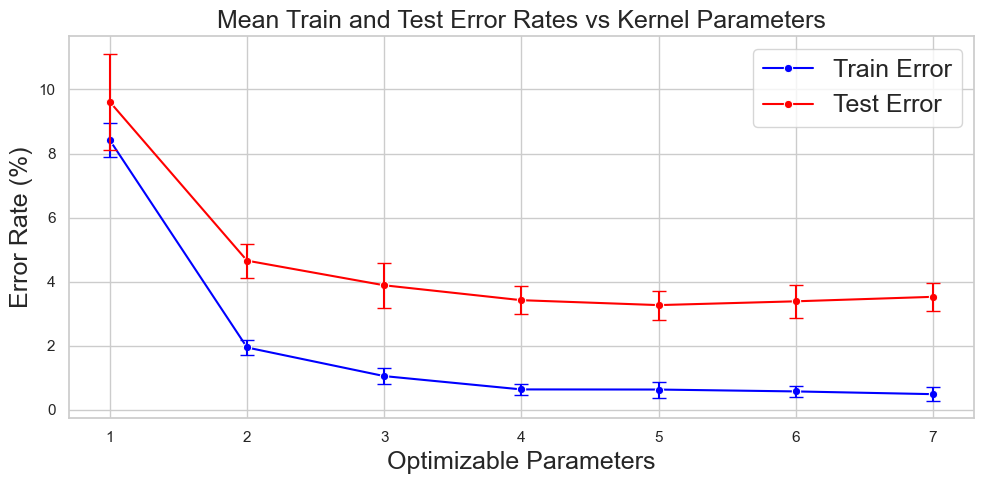

In [10]:
def plot_error_rates(df_results, params_range, params_name, kernel_name):
    # Convert error rates to percentages
    df_results['Mean Train Error'] *= 100
    df_results['Mean Test Error'] *= 100
    df_results['Std Train Error'] *= 100
    df_results['Std Test Error'] *= 100

    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 5),dpi=100)

    # Plotting mean train error rates
    sns.lineplot(x=params_range, y='Mean Train Error', data=df_results,
                 label='Train Error', marker='o', color='blue')

    # Add error bars for train error
    plt.errorbar(params_range, df_results['Mean Train Error'],
                 yerr=df_results['Std Train Error'], fmt='none', capsize=5, color='blue')

    # Plot mean test error rates
    sns.lineplot(x=params_range, y='Mean Test Error', data=df_results,
                 label='Test Error', marker='o', color='red')

    # Add error bars for test error
    plt.errorbar(params_range, df_results['Mean Test Error'],
                 yerr=df_results['Std Test Error'], fmt='none', capsize=5, color='red')

    plt.title(f'Mean Train and Test Error Rates vs Kernel {kernel_name} Parameters',fontsize=18)
    plt.xlabel(f'Optimizable Parameters {params_name}',fontsize=18)
    plt.ylabel('Error Rate (%)',fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()

    # Show the plot
    plt.show()
    plt.savefig('error_rates_poly.png')
    
plot_error_rates(kernel_perceptron, d_range, 'd', 'polynomial')

## Q2

In [11]:
N_FOLDS = 5

def run_kernel_perceptron_cross_val(x_data, y_labels, N_RUNS, N_FOLDS, params_range, n_classes, kernel_function: callable):
    '''
    Runs the kernel perceptron with cross validation
    param x_data: the data
    param y_labels: the labels
    param N_RUNS: number of runs
    param N_FOLDS: number of folds
    param range: the range of d's or c to test
    param n_classes: number of classes
    param kernel_function: the kernel function to use
    return: test_errors, d_stars, confusion_matrices, misclassified_images
    '''
    fold_test_prediction_error = np.zeros(shape=(N_RUNS, N_FOLDS, len(d_range)))
    test_errors = np.zeros(shape=(N_RUNS))
    confusion_matrices = np.zeros(shape=(N_RUNS, n_classes, n_classes))
    misclassified_images = {}
    test_errors = np.zeros(N_RUNS)
    star_params = []
    fold_test_prediction_error = np.zeros((N_RUNS, N_FOLDS, len(params_range)))

    #loop over the runs
    for i_run in range(N_RUNS):
        #split the data into train and test
        X_train, X_test, Y_train, Y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
        #create the folds
        folds_data: list[FoldData] = create_folds_data(X_train, Y_train, number_of_folds=N_FOLDS)
        #loop over the folds
        for i_fold, fold in enumerate(folds_data):
            #loop over the d's
            for i_j, j in enumerate(params_range):
                #calculate the kernel matrix for the train and test data
                K_train_fold = kernel_function(fold.train_data, fold.train_data, j)
                K_test_fold = kernel_function(fold.test_data, fold.train_data, j)
                
                #train the kernel perceptron
                alpha = train_kernel_perceptron_online(fold.train_data, fold.train_labels, K_train_fold, n_classes, return_training_error=False)
                #calculate the prediction error for each run, fold and d
                fold_test_prediction_error[i_run, i_fold, i_j] = predict_kernel_perceptron(fold.test_labels, alpha, K_test_fold)

        #calculate the d_star/c_star for each run
        star_param, _ = get_d_star_from_cross_validation_error(fold_test_prediction_error[i_run, :, :], ds=params_range)
        star_params.append(star_param)
        
        #train the kernel perceptron with the d_star/c_star
        K_train = kernel_function(X_train, X_train, star_param)
        alpha_star = train_kernel_perceptron_online(X_train, Y_train, K_train, n_classes, return_training_error=False)
        #calculate the test error for each run and d_star/c_star
        K_test = kernel_function(X_test, X_train, star_param)
        test_errors[i_run], y_pred = predict_kernel_perceptron(Y_test, alpha_star, K_test, return_labels=True)
        
        #calculate the confusion matrix for each run and d_star/c_star
        confusion_matrices[i_run, :, :] = confusion_matrix(Y_test, y_pred)
        
        #record the misclassified images for each run and d_star/c_star
        misclassified_indices = np.where(y_pred!=Y_test)[0]
        misclassified_images[i_run] = {}
        for index in misclassified_indices:
            true_label = Y_test[index]
            misclassified_images[i_run][true_label] = X_test[index]

    return test_errors, star_params, confusion_matrices, misclassified_images

test_errors_poly, d_stars, confusion_matrices, misclassified_images = run_kernel_perceptron_cross_val(x_data, y_labels, N_RUNS, N_FOLDS, d_range, n_classes, kernel_function=polynomial_kernel)

Epoch 1, number of samples 5951, mistakes this epoch 961
Epoch 2, number of samples 5951, mistakes this epoch 596
Epoch 3, number of samples 5951, mistakes this epoch 509
Epoch 4, number of samples 5951, mistakes this epoch 479
Epoch 1, number of samples 5951, mistakes this epoch 670
Epoch 2, number of samples 5951, mistakes this epoch 271
Epoch 3, number of samples 5951, mistakes this epoch 159
Epoch 4, number of samples 5951, mistakes this epoch 137
Epoch 1, number of samples 5951, mistakes this epoch 577
Epoch 2, number of samples 5951, mistakes this epoch 206
Epoch 3, number of samples 5951, mistakes this epoch 87
Epoch 4, number of samples 5951, mistakes this epoch 56
Epoch 1, number of samples 5951, mistakes this epoch 550
Epoch 2, number of samples 5951, mistakes this epoch 143
Epoch 3, number of samples 5951, mistakes this epoch 58
Epoch 4, number of samples 5951, mistakes this epoch 37
Epoch 1, number of samples 5951, mistakes this epoch 539
Epoch 2, number of samples 5951, mi

In [12]:
print(d_stars)
print(test_errors_poly)
def calculate_mean_star_param_and_mean_test_error_with_std(test_errors, stars_param, param):
    mean_cross_validation_test_error_with_star_param = np.mean(test_errors, axis=0)
    mean_cross_validation_test_error_std_with_star_param = np.std(test_errors, axis=0)
    mean_cross_validation_star_param = np.mean(stars_param)
    mean_cross_validation_std_star_param = np.std(stars_param)
    print("Mean Test Error {param}: ", mean_cross_validation_test_error_with_star_param, "±", mean_cross_validation_test_error_std_with_star_param)
    print("Mean Best {param}", mean_cross_validation_star_param, "±", mean_cross_validation_std_star_param)

    part_2_results = {
            f"Mean Best {param}": mean_cross_validation_star_param,
            f"Mean Best {param} standard deviation": mean_cross_validation_std_star_param,
            "Mean Test Error": mean_cross_validation_test_error_with_star_param,
            "Test Error Standard Deviation": mean_cross_validation_test_error_std_with_star_param
        }

    df_results_2 = pd.DataFrame.from_dict(part_2_results, orient='index')
    df_results_2.reset_index(inplace=True)
    
    return df_results_2, mean_cross_validation_star_param

df_results_2, mean_cross_validation_d_star = calculate_mean_star_param_and_mean_test_error_with_std(test_errors_poly, d_stars, 'd')
df_results_2


[5, 6, 5, 5, 6, 5, 5, 4, 6, 4, 7, 6, 4, 5, 5, 7, 6, 5, 7, 6]
[0.03333333 0.02956989 0.02903226 0.03655914 0.0344086  0.03602151
 0.03387097 0.02741935 0.02795699 0.03709677 0.03763441 0.02849462
 0.03870968 0.02849462 0.03010753 0.0311828  0.04569892 0.03602151
 0.03978495 0.03172043]
Mean Test Error {param}:  0.03365591397849462 ± 0.004697460464258662
Mean Best {param} 5.45 ± 0.9205976319760985


,index,0
0,Mean Best d,5.450000
1,Mean Best d standard diviation,0.920598
2,Mean Test Error,0.033656
3,Test Error Standard Diviation,0.004697


In [13]:
df_results_2

,index,0
0,Mean Best d,5.450000
1,Mean Best d standard diviation,0.920598
2,Mean Test Error,0.033656
3,Test Error Standard Diviation,0.004697


## Q3

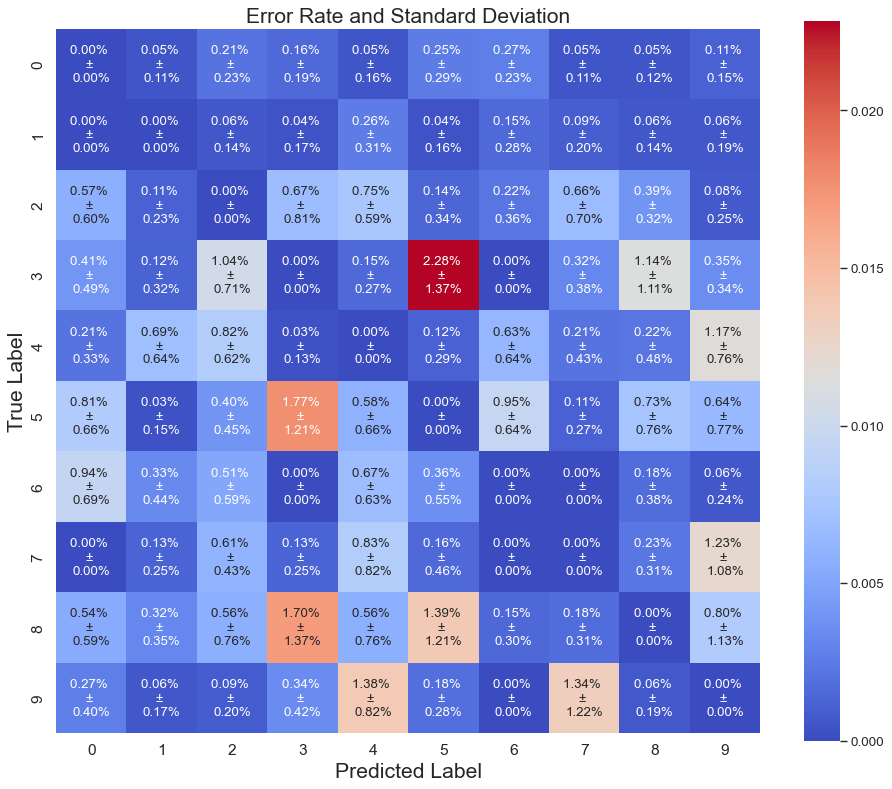

<Figure size 640x480 with 0 Axes>

In [14]:
def plot_confusion_matrix(confusion_matrices):
    std_dev_matrix = calculate_confusion_matrix_std(confusion_matrices)
    mean_confusion_matrix = confusion_matrices.mean(axis=0)
    combined_matrix = np.vectorize(lambda mean, std: f"{mean*100:.2f}% \n± \n{std*100:.2f}%")(mean_confusion_matrix, std_dev_matrix)

    plt.figure(figsize=(12, 10), dpi=80)
    sns.set(style="whitegrid", font_scale=1.1)
    ax = sns.heatmap(mean_confusion_matrix, annot=combined_matrix, fmt="", cmap='coolwarm', cbar=True, square=True, annot_kws={"size": 12}, xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.title("Error Rate and Standard Deviation", fontsize=19)
    plt.xlabel('Predicted Label', fontsize=19)
    plt.ylabel('True Label', fontsize=19)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()
    plt.savefig('confusion_matrix.png')
    
plot_confusion_matrix(confusion_matrices)

## Q4

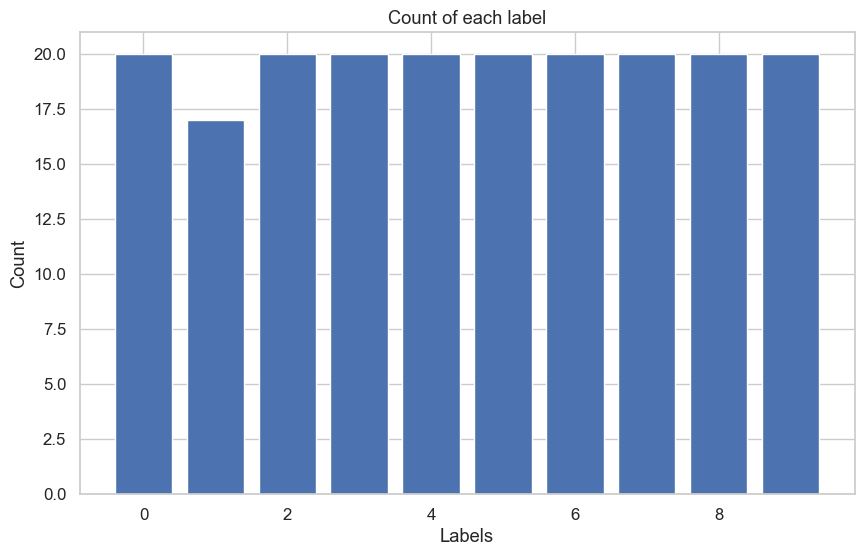

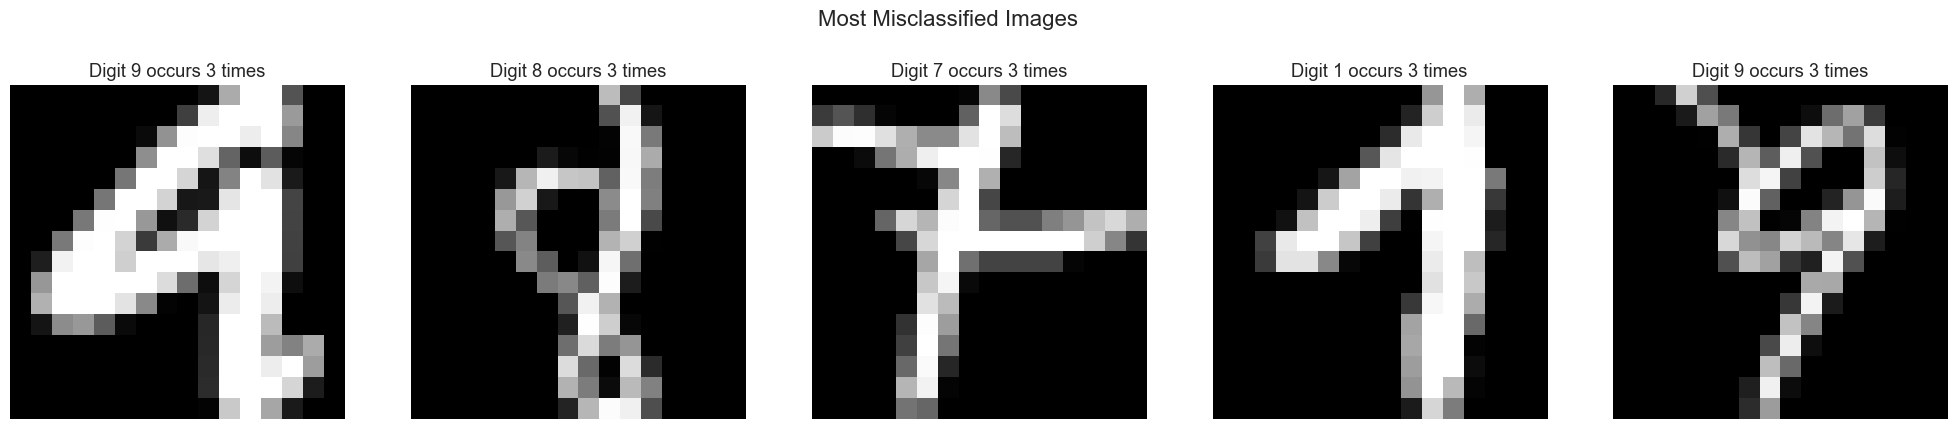

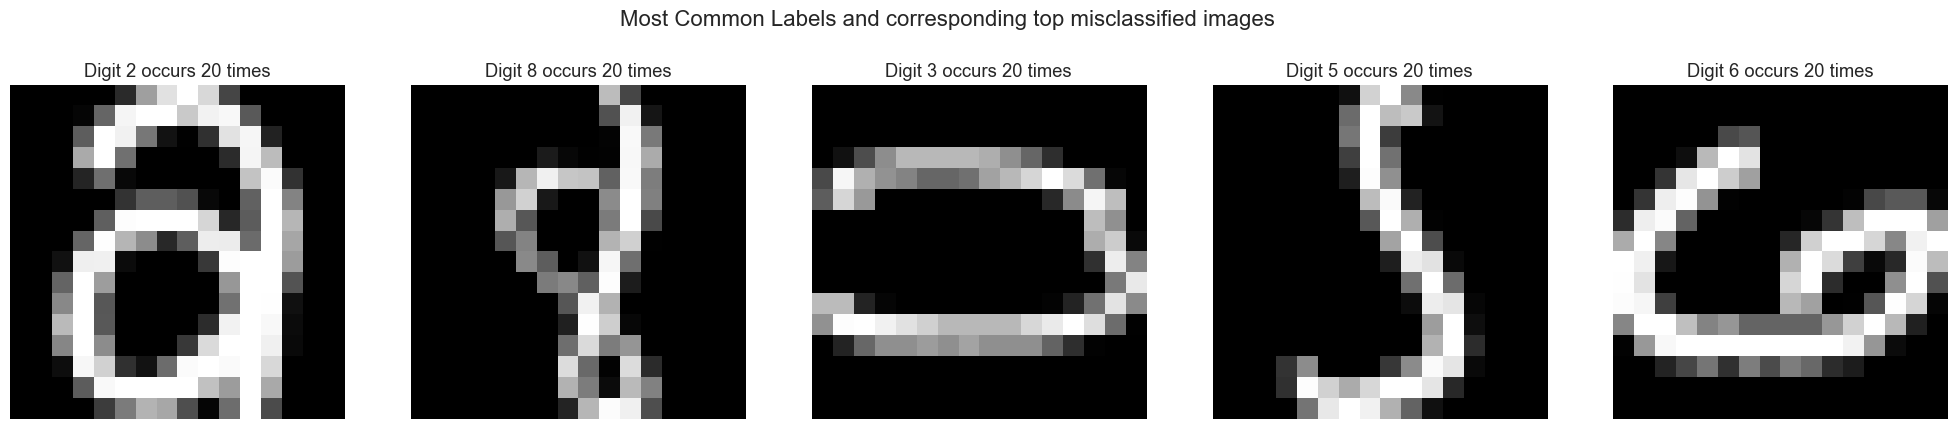

In [15]:
def plot_label_counts(label_counts):
    plt.figure(figsize=(10,6))
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Count of each label')
    plt.show()
    
def get_first_image_by_label(label):
    for image_dict in image_data:
        if image_dict['label'] == label:
            return image_dict['image']

# Initialize counters and data list
label_counts = Counter()
image_counts = Counter()
image_data = []

# Count labels and images
for i_run, labels in misclassified_images.items():
    for label, image in labels.items():
        image = tuple(image.flatten())
        label_counts[label] += 1
        image_counts[image] += 1

        # Add new image data or update count of existing image data
        for image_dict in image_data:
            if image_dict['image'] == image:
                image_dict['count'] = image_counts[image]
                break
        else:
            image_data.append({'image': image, 'count': image_counts[image], 'label': label})

plot_label_counts(label_counts)

# Sort image data by count in descending order
image_data.sort(key=lambda x: x['count'], reverse=True)

# Get the 5 most common images
most_common_images = image_data[:5]

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle('Most Misclassified Images', fontsize=16)

# Display each of the 5 most common images in its own subplot
for ax, data in zip(axes, most_common_images):
    image, count, label = data['image'], data['count'], data['label']
    image = np.array(image).reshape(16, 16)
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Digit {label} occurs {count} times")

plt.show()

fig2, axes2 = plt.subplots(1, 5, figsize=(25, 5))
fig2.suptitle('Most Common Labels and corresponding top misclassified images', fontsize=16)
most_common_labels = label_counts.most_common(5)

for ax, (label, count) in zip(axes2, most_common_labels):
    image1 = np.array(get_first_image_by_label(label)).reshape(16, 16)
    ax.imshow(image1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Digit {label} occurs {count} times")

plt.show()

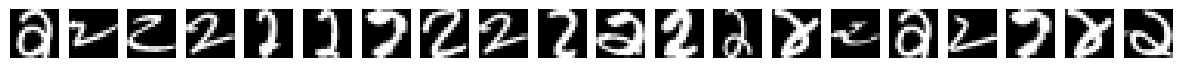

In [16]:
most_misclassified_label = max(label_counts, key=label_counts.get)
label_counter = Counter(label_counts)
most_common_labels = label_counter.most_common(5)
most_misclassified_images = []
for i_run in misclassified_images:
    if most_misclassified_label in misclassified_images[i_run]:
        most_misclassified_images.append(misclassified_images[i_run][most_misclassified_label])

fig, axes = plt.subplots(1, len(most_misclassified_images), figsize=(15, 5))

for ax, image in zip(axes, most_misclassified_images):
    
    data = image.reshape(16, 16)
    ax.imshow(data, cmap='gray')
    ax.axis('off')

plt.show()

## Q5

In [17]:
c_range = [0.001, 0.01, 0.1, 1, 10, 100]
mean_train_errors_gauss, mean_test_errors_gauss, mean_std_train_errors_gauss, mean_std_test_errors_gauss = run_experiment_without_cross_val(x_data, y_labels, N_RUNS, c_range, n_classes, kernel_function=gaussian_kernel_matrix)

Epoch 1, number of samples 7438, mistakes this epoch 1463
Epoch 2, number of samples 7438, mistakes this epoch 807
Epoch 3, number of samples 7438, mistakes this epoch 630
Epoch 4, number of samples 7438, mistakes this epoch 603
Run 0, degree 0.001, train error 0.0810701801559559, number of samples 7438
Run 0, degree 0.001, train error 2 0.050551223447163215, number of samples 7438
Run 0, degree 0.001, test error 0.06182795698924731, number of samples 1860
Epoch 1, number of samples 7438, mistakes this epoch 658
Epoch 2, number of samples 7438, mistakes this epoch 126
Epoch 3, number of samples 7438, mistakes this epoch 78
Run 0, degree 0.01, train error 0.010486689970422156, number of samples 7438
Run 0, degree 0.01, train error 2 0.00860446356547459, number of samples 7438
Run 0, degree 0.01, test error 0.03870967741935484, number of samples 1860
Epoch 1, number of samples 7438, mistakes this epoch 686
Epoch 2, number of samples 7438, mistakes this epoch 124
Epoch 3, number of sample

In [18]:
mean_train_errors_gauss

array([0.07767545, 0.00772385, 0.00059828, 0.00022183, 0.0004235 ,
       0.        ])

In [19]:
# Create a summary table
columns = ['sigma', 'Mean Train Error', 'Std Train Error', 'Mean Test Error', 'Std Test Error']

# Take an average over all the runs
kernel_perceptron_gauss = pd.concat((
    pd.DataFrame(mean_train_errors_gauss, columns=[columns[1]]),
    pd.DataFrame(mean_std_train_errors_gauss,columns=[columns[2]]),
    pd.DataFrame(mean_test_errors_gauss, columns=[columns[3]]),
    pd.DataFrame(mean_std_test_errors_gauss, columns=[columns[4]])), axis=1
)
kernel_perceptron_gauss.set_index((pd.Series(c_range, name='c')), inplace=True)
kernel_perceptron_gauss.index.name = 'sigma'

kernel_perceptron_gauss

,Mean Train Error,Std Train Error,Mean Test Error,Std Test Error
sigma,,,,
0.001,0.077675,0.005245,0.084140,0.018217
0.010,0.007724,0.002779,0.035430,0.004202
0.100,0.000598,0.000424,0.048253,0.005281
1.000,0.000222,0.000310,0.061855,0.004255
10.000,0.000424,0.000346,0.195806,0.007152
100.000,0.000000,0.000000,0.715296,0.009152


c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

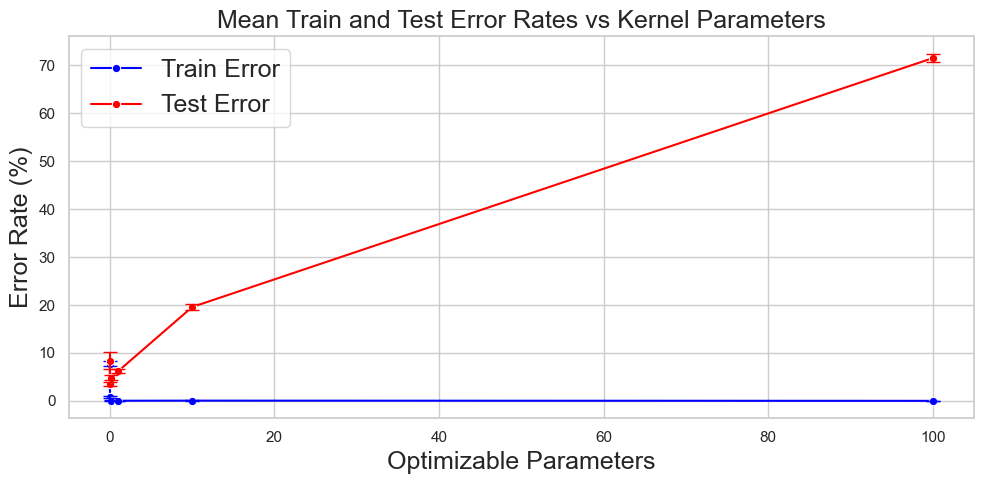

In [20]:
plot_error_rates(kernel_perceptron_gauss, c_range)

In [21]:
test_errors_gauss, c_stars, confusion_matrices, misclassified_images = run_kernel_perceptron_cross_val(x_data, y_labels, N_RUNS, N_FOLDS, c_range, n_classes, kernel_function=gaussian_kernel_matrix)

Epoch 1, number of samples 5951, mistakes this epoch 1231
Epoch 2, number of samples 5951, mistakes this epoch 692
Epoch 3, number of samples 5951, mistakes this epoch 556
Epoch 4, number of samples 5951, mistakes this epoch 483
Epoch 5, number of samples 5951, mistakes this epoch 427
Epoch 1, number of samples 5951, mistakes this epoch 564
Epoch 2, number of samples 5951, mistakes this epoch 131
Epoch 3, number of samples 5951, mistakes this epoch 48
Epoch 4, number of samples 5951, mistakes this epoch 41
Epoch 1, number of samples 5951, mistakes this epoch 603
Epoch 2, number of samples 5951, mistakes this epoch 115
Epoch 3, number of samples 5951, mistakes this epoch 11
Epoch 4, number of samples 5951, mistakes this epoch 0
Epoch 1, number of samples 5951, mistakes this epoch 647
Epoch 2, number of samples 5951, mistakes this epoch 141
Epoch 3, number of samples 5951, mistakes this epoch 14
Epoch 4, number of samples 5951, mistakes this epoch 2
Epoch 1, number of samples 5951, mista

In [22]:
c_stars
test_errors_gauss
print(c_stars)
print(test_errors_gauss)

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
[0.03870968 0.03010753 0.03817204 0.0344086  0.03010753 0.03817204
 0.0344086  0.03225806 0.03763441 0.04032258 0.03494624 0.03709677
 0.03817204 0.03387097 0.03010753 0.02956989 0.04677419 0.03655914
 0.03064516 0.03655914]


Mean Test Error {param}:  0.035430107526881714 ± 0.004202155490251426
Mean Best {param} 0.010000000000000002 ± 1.734723475976807e-18


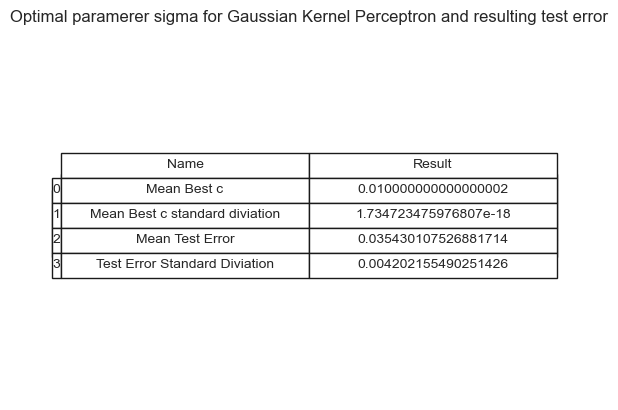

In [23]:
df_c_star_results, mean_cross_validation_c_star = calculate_mean_star_param_and_mean_test_error_with_std(test_errors_gauss, c_stars, 'c')
df_c_star_results
df_c_star_results.rename(columns={
    'index': 'Name',
    0: 'Result',
    # Add more columns here if needed
}, inplace=True)
fig, ax = plt.subplots(1, 1)

table_data = df_c_star_results.values.tolist()
column_labels = df_c_star_results.columns.tolist()
row_labels = df_c_star_results.index.tolist()

ax.axis('tight')
ax.axis('off')
ax.table(cellText=table_data, colLabels=column_labels, rowLabels=row_labels, cellLoc = 'center', loc='center')
table = ax.table(cellText=table_data, colLabels=column_labels, rowLabels=row_labels, cellLoc = 'center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
ax.set_title('Optimal paramerer sigma for Gaussian Kernel Perceptron and resulting test error') 
plt.show()

## Q6

In [24]:
num_classifiers = 100
X_initial, X_test, y_initial, y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
def train_ensemble_classifiers(data, kernel_function, kernel_param, num_classifiers):
    classifiers = []

    for i_class in range(num_classifiers):
        X_train, X_test, y_train, y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )

        K_train = kernel_function(X_train, X_train, kernel_param)
        
        alpha = train_kernel_perceptron_online(X_train, y_train, K_train, n_classes, return_training_error=False)
        classifiers.append(alpha)

        # calculating prediction of the test data
        K_test = kernel_function(X_test, X_train, j)
        test_errors[i_run, j_ind] = predict_kernel_perceptron(y_test, alpha, K_test)
        print(f"Run {i_run}, degree {j}, test error {test_errors[i_run, j_ind]}, number of samples {len(X_test)}")

    return classifiers

classifiers = train_ensemble_classifiers(X_initial, mean_cross_validation_c_star, num_classifiers, kernel_function=gaussian_kernel_matrix)



TypeError: train_ensemble_classifiers() got multiple values for argument 'kernel_function'

In [ ]:
## BAD CODE DEMO

# Function to compute the polynomial kernel of degree 3
def compute_kernel(a, b):
    return (np.dot(a, b))**3

# Function to compute the sign of a number
def compute_sign(x):
    return -1.0 if x <= 0.0 else 1.0

# Function to initialize the classifier weights
def initialize_weights(data):
    return np.zeros((3, len(data)))

# Function to compute the prediction for a given pattern
def compute_prediction(data, pattern, classifier):
    return sum(classifier[i] * compute_kernel(pattern, data[i][1:]) for i in range(len(classifier)))

# Function to train the classifiers
def train_classifiers(data):
    global classifier_weights
    classifier_weights = initialize_weights(data)
    num_mistakes = 0

    for i in range(len(data)):
        true_class = data[i][0]

        # Compute the predictions of the 3 classifiers
        predictions = [compute_prediction(data, data[i][1:], classifier_weights[j]) for j in range(3)]
        
        max_prediction = float("-inf")
        for j in range(3):
            expected_output = 1.0 if true_class == (j + 1) else -1.0
            
            # Update the classifier weights if the prediction is incorrect
            if expected_output * predictions[j] <= 0:
                classifier_weights[j, i] -= compute_sign(predictions[j])
            if predictions[j] > max_prediction:
                max_prediction = predictions[j]
                predicted_class = j + 1
                
        # Increment the mistake counter if the predicted class is not the true class
        if predicted_class != true_class:
            num_mistakes += 1

    return num_mistakes

# Train the model and get the number of mistakes
mistakes = train_classifiers(training_data)
print("Number of mistakes:", mistakes)

# Access the global variable GLBcls after training
print("GLBcls shape:", classifier_weights.shape)